<h1 style='color:#3469e5'><b> Libs usadas nesse projeto <i></i>:</b></h1>

In [1]:
import requests, zipfile, io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import ttest_ind


<h1 style='color:#3469e5'><b> Abrindo o dataset <i></i>:</b></h1>


Escolhi essa abordagem para abrir o dataset, pois não fazer o download do arquivo estava me custando mais processamento do que tenho disponível.

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip'
r = requests.get(url, stream=True,verify=False)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

C:\Users\Carol\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [3]:
z.namelist()

['bank-full.csv', 'bank-names.txt', 'bank.csv']

In [4]:
df = pd.read_csv('bank-full.csv', sep=';')

In [5]:
df.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
df.describe()

age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       -1.000000      0.000000  
max      871.000000    275.000000

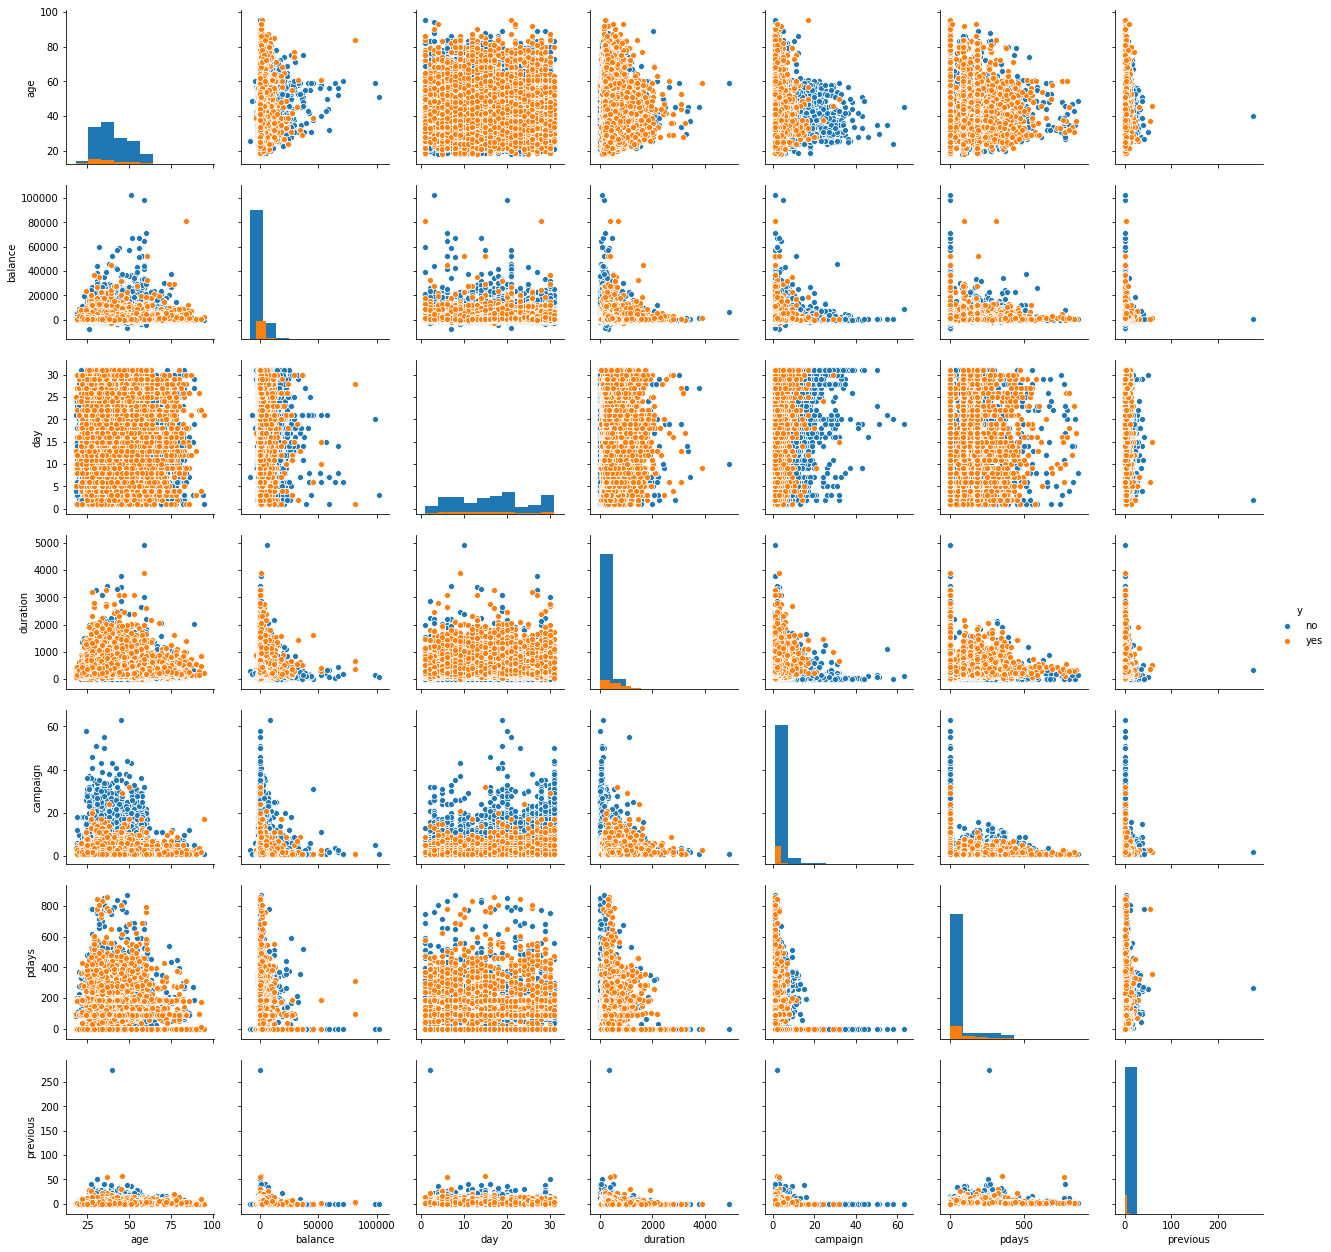

In [8]:
sns.pairplot(df,
            hue='y',
            diag_kind='hist')

In [9]:
profile = ProfileReport(df)
profile

In [10]:
# transformando algumas dimenções em binário para facilitar análise.
df.replace('yes', 1, inplace=True)
df.replace('no', 0, inplace=True)

<h1 style='color:#3469e5'><b> 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?  <i></i></b></h1>


Olhando o gráfico podemos observar que neste dataset os blue-collar pega 26,9% mais empréstimos que o restante das profissões e 80,7% desses empréstimos é imobiliário. Optei em fazer essa análise pois com as variáveis que compõem esse dataset não tive tempo hábil de analisar de forma preditiva qual profissão pedirá um empréstimo e em quanto tempo.

In [11]:
pivot = df.pivot_table(index=["job"], values = ['loan', 'housing'], aggfunc=np.sum).sort_values(by=['loan','housing'],ascending=False)

In [12]:
T = pivot['loan'].sum() + pivot['housing'].sum()

In [13]:
(pivot['loan'][0] + pivot['housing'][0]) / T *100 #% de blue-collar

26.97226169148082

In [14]:
pivot['housing'][0] / (pivot['loan'][0] + pivot['housing'][0]) *100 #% de emprestimo imobiliário para blue-collar

80.71461291800274

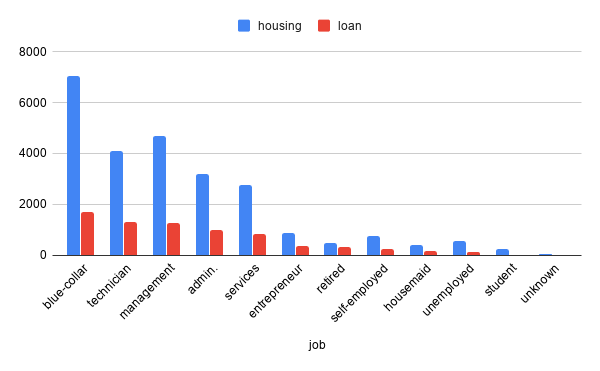

In [17]:
from IPython.display import Image
Image(filename='grafico-profissões.png') 

<h1 style='color:#3469e5'><b> 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes a serem observados?   <i></i></b></h1>


O ponto que mais me chamou a atenção foi o número de ligações necessárias para realizar uma venda. 23.6 ligações é um número muito alto, há a necessidade de otimizar esse processo por que o grande número de ligações não está correlacionado a chance de sucesso.

In [18]:
#transformando as variáveis categóricas em binárias
df_dummies = pd.get_dummies(df, dtype=str)

In [19]:
# Limpezinha
df_dummies.rename(columns={'job_admin.' : 'job_admin'}, inplace=True)
df_dummies.replace('' , 0 , inplace=True)
df_dummies = df_dummies.astype(int)

In [20]:
def plot_corr(corr):
    # Cortei a metade de cima pois é o espelho da metade de baixo
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask, 1)] = True
    f, ax = plt.subplots(figsize=(45, 15))
    sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9),
            square=True, ax=ax)

In [21]:
df_dummies['y'].corr(df_dummies['campaign']) #correlação fortemente negativa

-0.07317200634586693

In [22]:
df_dummies['campaign'].sum() / df_dummies['y'].sum() #numero de ligações para 1 venda

23.625638116846286

In [23]:
why = df_dummies.loc[df_dummies['y'] == 1]

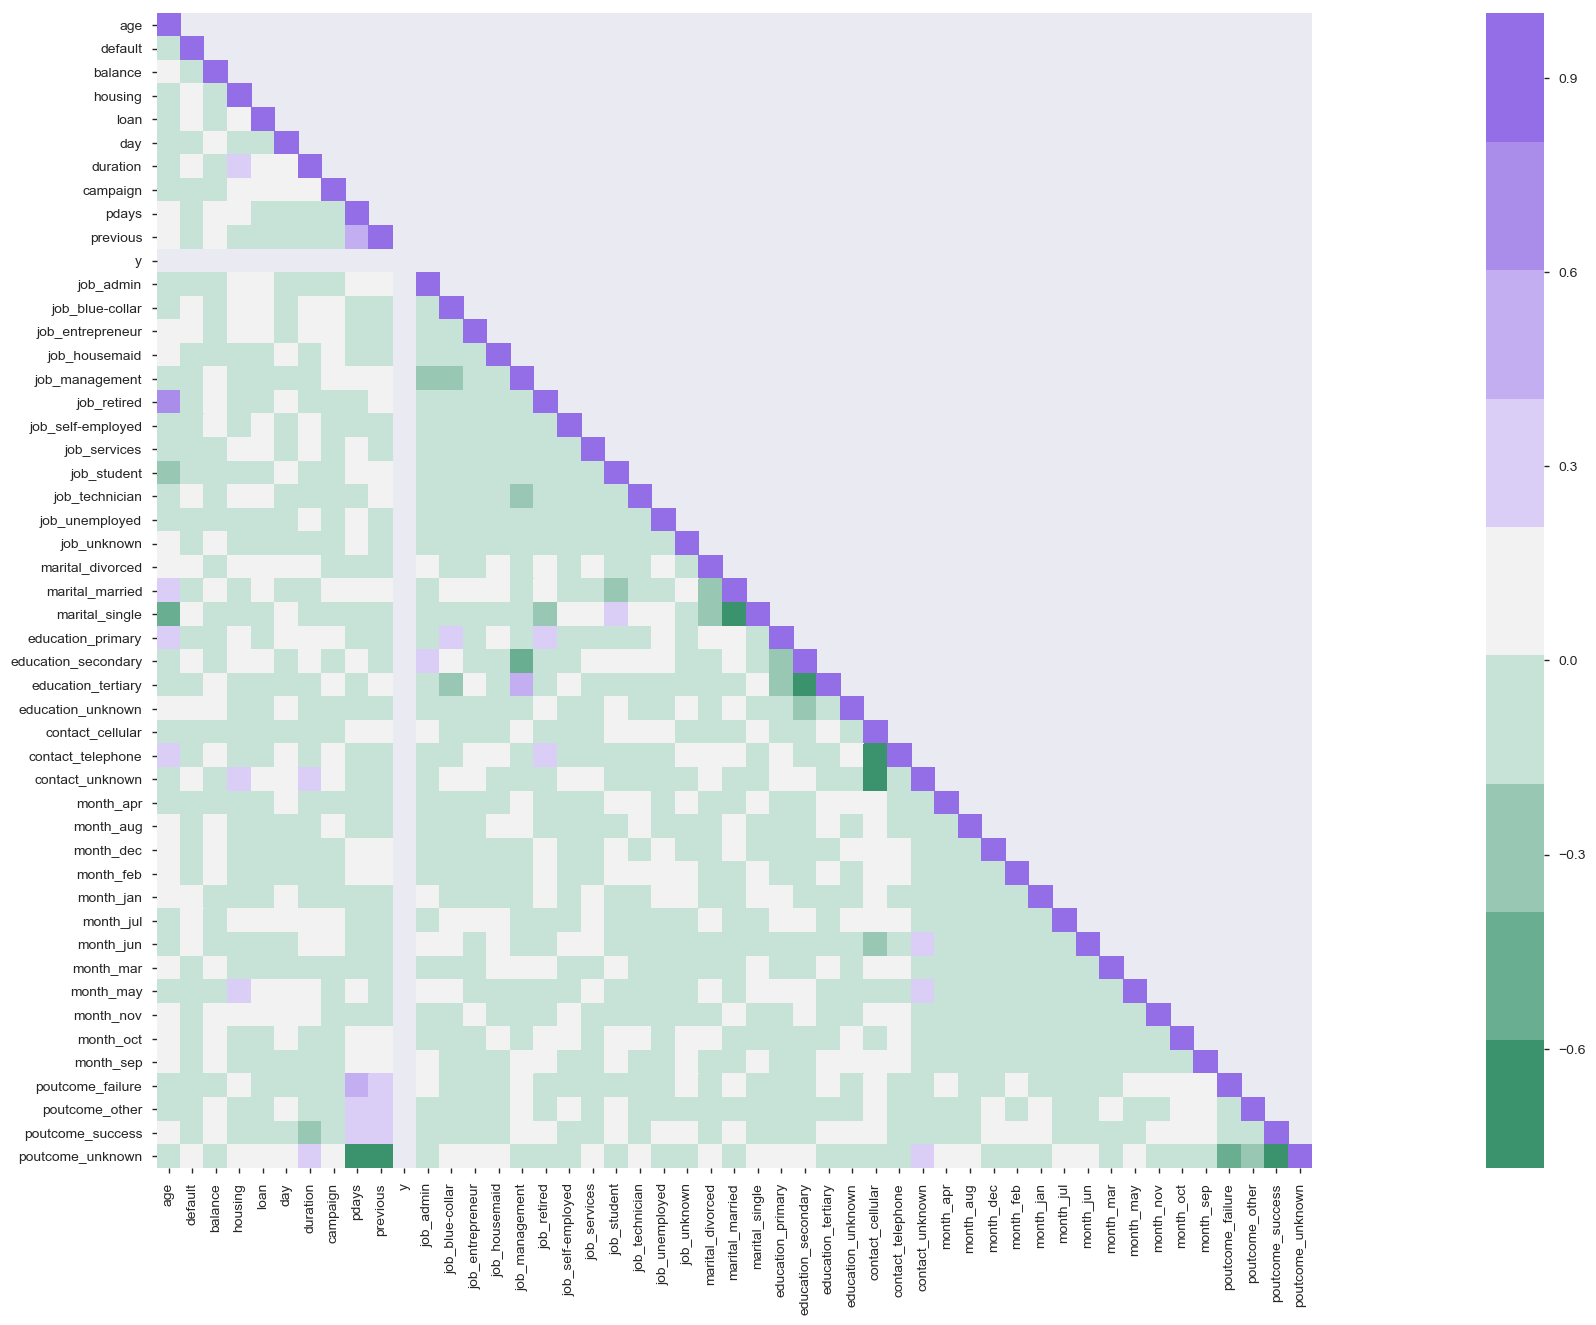

In [24]:
plot_corr(why.corr()) # Correlação do sucesso

<h1 style='color:#3469e5'><b> 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão? <i></i></b></h1>

Seguindo os resultados abaixo, me baseando nos casos de sucesso. A média de ligações deve ser 2 e o máximo de ligações visando 90% de sucesso é 4 ligações.

In [25]:
T = df['campaign'].sum() #total de ligações nessa campanha
T

124956

In [26]:
df['y'].value_counts() #proporção de sucesso da campanha atual

0    39922
1     5289
Name: y, dtype: int64

In [27]:
df.pivot_table(values=['campaign'], index=['y'],aggfunc=np.sum)

campaign
y          
0    113632
1     11324

In [28]:
dist_success = df.loc[df['y'] == 1]
dist_failure = df.loc[df['y'] == 0]

In [29]:
dist_failure.describe()

age       default        balance       housing          loan  \
count  39922.000000  39922.000000   39922.000000  39922.000000  39922.000000   
mean      40.838986      0.019112    1303.714969      0.581008      0.169330   
std       10.172662      0.136921    2974.195473      0.493400      0.375048   
min       18.000000      0.000000   -8019.000000      0.000000      0.000000   
25%       33.000000      0.000000      58.000000      0.000000      0.000000   
50%       39.000000      0.000000     417.000000      1.000000      0.000000   
75%       48.000000      0.000000    1345.000000      1.000000      0.000000   
max       95.000000      1.000000  102127.000000      1.000000      1.000000   

                day      duration      campaign         pdays      previous  \
count  39922.000000  39922.000000  39922.000000  39922.000000  39922.000000   
mean      15.892290    221.182806      2.846350     36.421372      0.502154   
std        8.294728    207.383237      3.212767     96.757135      2.256771   
min        1.000000      0.000000      1.000000     -1.000000      0.000000   
25%        8.000000     95.000000      1.000000     -1.000000      0.000000   
50%       16.000000    164.000000      2.000000     -1.000000      0.000000   
75%       21.000000    279.000000      3.000000     -1.000000      0.000000   
max       31.000000   4918.000000     63.000000    871.000000    275.000000   

             y  
count  39922.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

In [30]:
dist_success.describe()

age      default       balance      housing         loan  \
count  5289.000000  5289.000000   5289.000000  5289.000000  5289.000000   
mean     41.670070     0.009832   1804.267915     0.365854     0.091511   
std      13.497781     0.098676   3501.104777     0.481714     0.288361   
min      18.000000     0.000000  -3058.000000     0.000000     0.000000   
25%      31.000000     0.000000    210.000000     0.000000     0.000000   
50%      38.000000     0.000000    733.000000     0.000000     0.000000   
75%      50.000000     0.000000   2159.000000     1.000000     0.000000   
max      95.000000     1.000000  81204.000000     1.000000     1.000000   

               day     duration     campaign        pdays     previous       y  
count  5289.000000  5289.000000  5289.000000  5289.000000  5289.000000  5289.0  
mean     15.158253   537.294574     2.141047    68.702968     1.170354     1.0  
std       8.501875   392.525262     1.921826   118.822266     2.553272     0.0  
min       1.000000     8.000000     1.000000    -1.000000     0.000000     1.0  
25%       8.000000   244.000000     1.000000    -1.000000     0.000000     1.0  
50%      15.000000   426.000000     2.000000    -1.000000     0.000000     1.0  
75%      22.000000   725.000000     3.000000    98.000000     1.000000     1.0  
max      31.000000  3881.000000    32.000000   854.000000    58.000000     1.0

<h1 style='color:#3469e5'><b> 4. O resultado da campanha anterior tem relevância na campanha atual? <i></i></b></h1>


Escolhi fazer um tests-t independente para responder a questão. A resposta estará no final do cálculo.

In [31]:
passada = df_dummies['poutcome_success'] 
atual = df_dummies['y']

In [33]:
atual_mean = np.mean(atual)
passada_mean = np.mean(passada)
print("Média da campanha atual:",atual_mean)
print("Média da campanha passada:",passada_mean)
atual_std = np.std(atual)
passada_std = np.std(passada)
print("Std da campanha atual:",atual_std)
print("Std da campanha passada:",passada_std)
ttest,pval = ttest_ind(atual,passada)
print("p-value",pval)
if pval <0.05:
  print("Rejeito a hipótese nula, uma campanha tem relevância para outra.")
else:
  print("Não rejeito a hipótese nula, uma campanha não tem relevância para outra.")

Média da campanha atual: 0.11698480458295547
Média da campanha passada: 0.0334210700935613
Std da campanha atual: 0.32140217808788435
Std da campanha passada: 0.1797334197286721
p-value 0.0
Rejeito a hipótese nula, uma campanha tem relevância para outra.


<h1 style='color:#3469e5'><b> 5. Qual o fator determinante para que o banco exija um seguro de crédito? <i></i></b></h1>


Dois fatores são determinantes para exigência do seguro de crédito, saldo e idade. Conforme veremos no gráfico abaixo.

In [34]:
#Para essa análise irei usar apenas as informações demográficas e bancárias do dataset
df_calote = df_dummies[['age', 'balance', 'housing', 'loan', 'y', 'job_admin', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default']]

C:\Users\Carol\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.26316625 0.67912783 0.01756245 0.00968796 0.008098   0.00666337
 0.01569415]


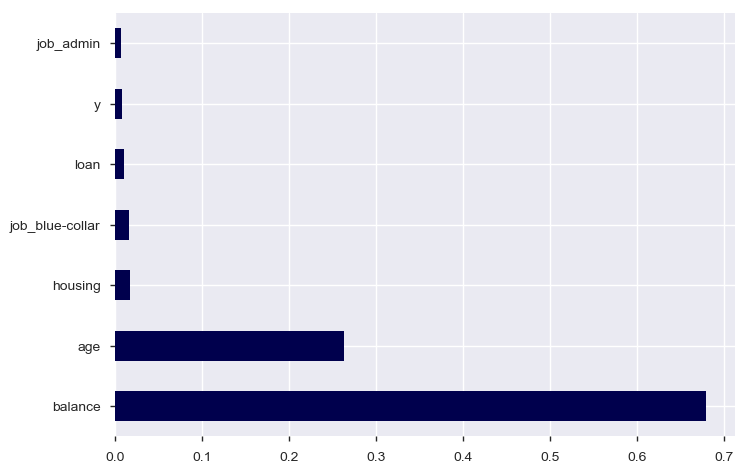

In [35]:
X = df_calote.iloc[:,0:7]  #independent columns
y = df_calote.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', cmap='seismic')
plt.show()

<h1 style='color:#3469e5'><b>6. Quais são as características mais proeminentes de um cliente que possua 
empréstimo imobiliário?  <i></i></b></h1>


<h1 style='color:#0a37a8;font-size:20px'><b>A maioria dos clientes que possuem crédito imobiliário tem as seguintes características:<i></i></b></h1>

* _Média de __39__ anos_
* Saldo anual médio de __EUR 1175,10__
* Trabalha como __operário__
* Tem __ensino secundário__
* É __casado__

Vou selecionar as features para fazer essa análise, mantendo a lógica de seleção usada na pergunta anterior. 

In [36]:
housing_success = df_calote.loc[df_calote['housing'] == 1] #separando a infor4mação pertinente

In [37]:
housing_success.describe()

age       balance  housing          loan             y  \
count  25130.000000  25130.000000  25130.0  25130.000000  25130.000000   
mean      39.175288   1175.103064      1.0      0.173776      0.077000   
std        8.926807   2483.285761      0.0      0.378925      0.266596   
min       20.000000  -4057.000000      1.0      0.000000      0.000000   
25%       32.000000     62.000000      1.0      0.000000      0.000000   
50%       38.000000    412.000000      1.0      0.000000      0.000000   
75%       45.000000   1257.750000      1.0      0.000000      0.000000   
max       78.000000  58544.000000      1.0      1.000000      1.000000   

          job_admin  job_blue-collar  job_entrepreneur  job_housemaid  \
count  25130.000000     25130.000000      25130.000000   25130.000000   
mean       0.126622         0.280462          0.034580       0.015838   
std        0.332555         0.449234          0.182718       0.124850   
min        0.000000         0.000000          0.000000       0.000000   
25%        0.000000         0.000000          0.000000       0.000000   
50%        0.000000         0.000000          0.000000       0.000000   
75%        0.000000         1.000000          0.000000       0.000000   
max        1.000000         1.000000          1.000000       1.000000   

       job_management  ...  job_unemployed   job_unknown  marital_divorced  \
count    25130.000000  ...    25130.000000  25130.000000      25130.000000   
mean         0.186152  ...        0.021608      0.001035          0.115678   
std          0.389237  ...        0.145401      0.032150          0.319845   
min          0.000000  ...        0.000000      0.000000          0.000000   
25%          0.000000  ...        0.000000      0.000000          0.000000   
50%          0.000000  ...        0.000000      0.000000          0.000000   
75%          0.000000  ...        0.000000      0.000000          0.000000   
max          1.000000  ...        1.000000      1.000000          1.000000   

       marital_married  marital_single  education_primary  \
count     25130.000000    25130.000000       25130.000000   
mean          0.609670        0.274652           0.154954   
std           0.487834        0.446348           0.361868   
min           0.000000        0.000000           0.000000   
25%           0.000000        0.000000           0.000000   
50%           1.000000        0.000000           0.000000   
75%           1.000000        1.000000           0.000000   
max           1.000000        1.000000           1.000000   

       education_secondary  education_tertiary  education_unknown  \
count         25130.000000        25130.000000       25130.000000   
mean              0.558615            0.253800           0.032630   
std               0.496562            0.435193           0.177671   
min               0.000000            0.000000           0.000000   
25%               0.000000            0.000000           0.000000   
50%               1.000000            0.000000           0.000000   
75%               1.000000            1.000000           0.000000   
max               1.000000            1.000000           1.000000   

            default  
count  25130.000000  
mean       0.017310  
std        0.130426  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 25 columns]

In [38]:
housing_success = df.loc[df['housing'] == 1] #Tabela anterior não respondeu completamente a questão.

In [39]:
housing_success['job'].value_counts()

blue-collar      7048
management       4678
technician       4115
admin.           3182
services         2766
entrepreneur      869
self-employed     765
unemployed        543
retired           491
housemaid         398
student           249
unknown            26
Name: job, dtype: int64

In [40]:
housing_success['education'].value_counts()

secondary    14038
tertiary      6378
primary       3894
unknown        820
Name: education, dtype: int64

In [41]:
housing_success['marital'].value_counts()

married     15321
single       6902
divorced     2907
Name: marital, dtype: int64